# **Task 1: Stochastic Gradient Descent**

In [211]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## Replicating the dataset from class

In [212]:
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = torch.linspace(domain[0], domain[1], sample_size)
    indices = torch.randperm(sample_size)
    x = x[indices]
    y = func(x) + torch.randn(x.size()) * std
    return x.view(-1, 1), y.view(-1, 1)

def sinusoidal(x):
    return torch.sin(2 * torch.pi * x)

In [213]:
x_train, y_train = create_toy_data(sinusoidal, sample_size=10, std=0.25)
x_test = torch.linspace(0, 1, 100).view(-1, 1)
y_test = sinusoidal(x_test)

# Define a variable for the number of features (variables) (M=9)

In [214]:
M = 9

x_train_multivar = torch.cat([x_train**i for i in range(1, M + 1)], dim=1)
x_test_multivar = torch.cat([x_test**i for i in range(1, M + 1)], dim=1)


## Defining a linear regression model with inclusion of M

In [215]:
class LinearRegression(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)


In [216]:
# Mean Squared Error Loss Function with L2 regularization (optional)
def mse_loss_with_regularization(model, y_pred, y_true, l2_lambda=0):
    mse_loss = torch.mean((y_pred - y_true) ** 2)
    l2_penalty = sum(param.pow(2).sum() for param in model.parameters())
    return mse_loss + l2_lambda * l2_penalty


In [217]:
# Stochastic Gradient Descent (SGD) manually implemented
def sgd_step(model, x_batch, y_batch, learning_rate, l2_lambda=0):
    y_pred = model(x_batch)
    loss = mse_loss_with_regularization(model, y_pred, y_batch, l2_lambda)

    # Compute gradients (backward pass)
    loss.backward()

    # Manually update the weights using gradient descent
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Clear the gradients after update
    model.zero_grad()

    return loss.item()


### **Hyperparameters**

The hyperparameters used in the model are:

- Learning Rate ($\alpha$): 0.01
- Number of Epochs: 1000
- Batch Size: 1
- L2 Regularization Strength ($\lambda$): 0.01
- Number of Features ($M$): 9

In [218]:
# Hyperparameters
learning_rate = 0.01
num_epochs = 1000
batch_size = 1
l2_lambda = 0.01  # Regularization strength


## **Equations used**


### **Loss Function**

The Mean Squared Error (MSE) loss function with L2 regularization is defined as:

$[
\text{Loss} = \frac{1}{N} \sum_{i=1}^{N} (y_{\text{pred}, i} - y_{\text{true}, i})^2 + \lambda \sum_{j=1}^{M} \theta_j^2
$]

*wherre:*
- *$(N$) is the number of samples.*
- *$(y_{\text{pred}, i}$) is the predicted output for sample $(i$).*
- *$(y_{\text{true}, i}$) is the true output for sample $(i$).*
- *$(\lambda$) is the L2 regularization strength (or penalty).*
- *$(\theta_j$) are the model parameters (weights).*

### **Gradient Descent Update Rule**

The update rule for gradient descent is:

$[
\theta_j \leftarrow \theta_j - \alpha \frac{\partial \text{Loss}}{\partial \theta_j}
$]

*where:*
- *$(\theta_j$) is the parameter being updated.*
- *$(\alpha$) is the learning rate.*
- *$(\frac{\partial \text{Loss}}{\partial \theta_j}$) is the gradient of the loss with respect to the parameter.*


## Function to train the model

In [219]:
def train_model(x_train, y_train, x_test, num_features, l2_lambda=0):
    model = LinearRegression(input_dim=num_features)
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]
            loss = sgd_step(model, x_batch, y_batch, learning_rate, l2_lambda)
            epoch_loss += loss

        losses.append(epoch_loss / len(x_train))

    return model, losses


In [220]:
model_with_reg, losses_with_reg = train_model(x_train_multivar, y_train, x_test_multivar, M, l2_lambda=l2_lambda)

model_without_reg, losses_without_reg = train_model(x_train_multivar, y_train, x_test_multivar, M, l2_lambda=0)


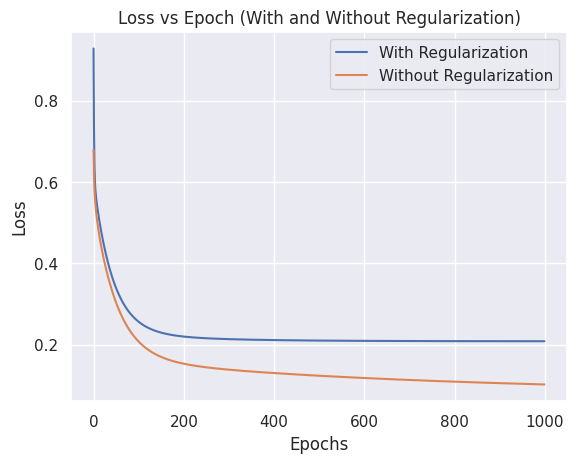

In [221]:
plt.plot(range(num_epochs), losses_with_reg, label='With Regularization')
plt.plot(range(num_epochs), losses_without_reg, label='Without Regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epoch (With and Without Regularization)')
plt.legend()
plt.show()


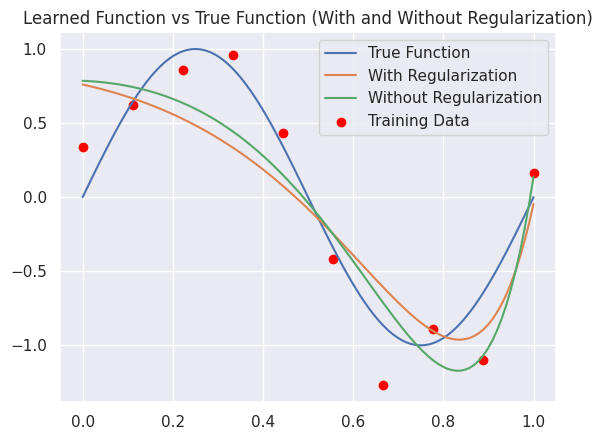

In [222]:
y_pred_test_with_reg = model_with_reg(x_test_multivar).detach()
y_pred_test_without_reg = model_without_reg(x_test_multivar).detach()

plt.plot(x_test, y_test, label='True Function')
plt.plot(x_test, y_pred_test_with_reg, label='With Regularization')
plt.plot(x_test, y_pred_test_without_reg, label='Without Regularization')
plt.scatter(x_train, y_train, color='red', label='Training Data')
plt.legend()
plt.title('Learned Function vs True Function (With and Without Regularization)')
plt.show()

# **Task 2: Momentum**

In [223]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [224]:
x_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
x_test = torch.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

In [225]:
class PolynomialFeature:
    def __init__(self, degree):
        self.degree = degree

    def transform(self, X):
        return torch.cat([X ** i for i in range(self.degree + 1)], dim=1)

In [226]:
M = 9
feature = PolynomialFeature(M)
X_train = feature.transform(x_train.unsqueeze(1))  # Add a dimension to x_train for transformation
X_test = feature.transform(x_test.unsqueeze(1))

# defining the cost function (Mean Squared Error Loss) using PyTorch only

In [227]:
def cal_cost(theta, X, y, alpha=0.01):
    m = y.size(0)
    predictions = X.matmul(theta)
    mse_loss = (1 / (2 * m)) * torch.sum((predictions - y) ** 2)
    reg_loss = (alpha / 2) * torch.sum(theta ** 2)
    cost = mse_loss + reg_loss
    return cost


In [228]:
def sgd(X, y, theta, learning_rate=0.01, iterations=1000, alpha=0.01):
    m = y.size(0)
    cost_history = torch.zeros(iterations)

    for it in range(iterations):
        cost = 0.0
        for i in range(m):
            rand_ind = torch.randint(0, m, (1,)).item()
            x_i = X[rand_ind, :].view(1, -1)
            y_i = y[rand_ind].view(1)
            prediction = x_i.matmul(theta)

            gradient = x_i.t().matmul(prediction - y_i) + alpha * theta
            with torch.no_grad():
                theta -= (learning_rate / m) * gradient

            cost += cal_cost(theta, x_i, y_i, alpha)

        cost_history[it] = cost / m

    return theta, cost_history


In [229]:
def sgd_momentum(X, y, theta, learning_rate=0.01, iterations=1000, alpha=0.01, momentum=0.9):
    m = y.size(0)
    cost_history = torch.zeros(iterations)
    velocity = torch.zeros_like(theta)

    for it in range(iterations):
        cost = 0.0
        for i in range(m):
            rand_ind = torch.randint(0, m, (1,)).item()
            x_i = X[rand_ind, :].view(1, -1)
            y_i = y[rand_ind].view(1)
            prediction = x_i.matmul(theta)


            gradient = x_i.t().matmul(prediction - y_i) + alpha * theta

            velocity = momentum * velocity + (learning_rate / m) * gradient

            with torch.no_grad():
                theta -= velocity
            cost += cal_cost(theta, x_i, y_i, alpha)

        cost_history[it] = cost / m

    return theta, cost_history


In [230]:
theta_sgd = torch.randn((X_train.size(1), 1), dtype=torch.float32, requires_grad=True)
theta_momentum = torch.randn((X_train.size(1), 1), dtype=torch.float32, requires_grad=True)

In [231]:
def initialize_theta(X_train):
    return torch.randn((X_train.size(1), 1), dtype  =torch.float32)

In [232]:
learning_rate = 0.01
iterations = 1000
alpha = 0.0
theta_no_reg = initialize_theta(X_train)
theta_no_reg, cost_history_no_reg = sgd(X_train, y_train, theta_no_reg, learning_rate=learning_rate, iterations=iterations, alpha=alpha)

In [233]:
alpha = 1e-3
theta_reg = initialize_theta(X_train)
theta_reg, cost_history_reg = sgd(X_train, y_train, theta_reg, learning_rate=learning_rate, iterations=iterations, alpha=alpha)

In [234]:
y_pred_no_reg = X_test.matmul(theta_no_reg)
y_pred_reg = X_test.matmul(theta_reg)

In [235]:
def moving_average(data, window_size):
    return torch.nn.functional.conv1d(data.unsqueeze(0).unsqueeze(0),
                                      torch.ones(1, 1, window_size) / window_size,
                                      padding=window_size//2).squeeze()


In [236]:
window_size = 50
cost_history_sgd_smooth = moving_average(cost_history_sgd.detach(), window_size)
cost_history_momentum_smooth = moving_average(cost_history_momentum.detach(), window_size)


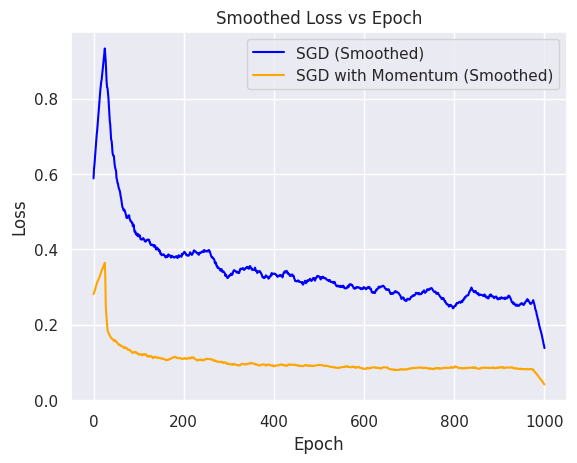

In [237]:
plt.plot(cost_history_sgd_smooth, label="SGD (Smoothed)", color='blue')
plt.plot(cost_history_momentum_smooth, label="SGD with Momentum (Smoothed)", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Smoothed Loss vs Epoch")
plt.legend()
plt.show()


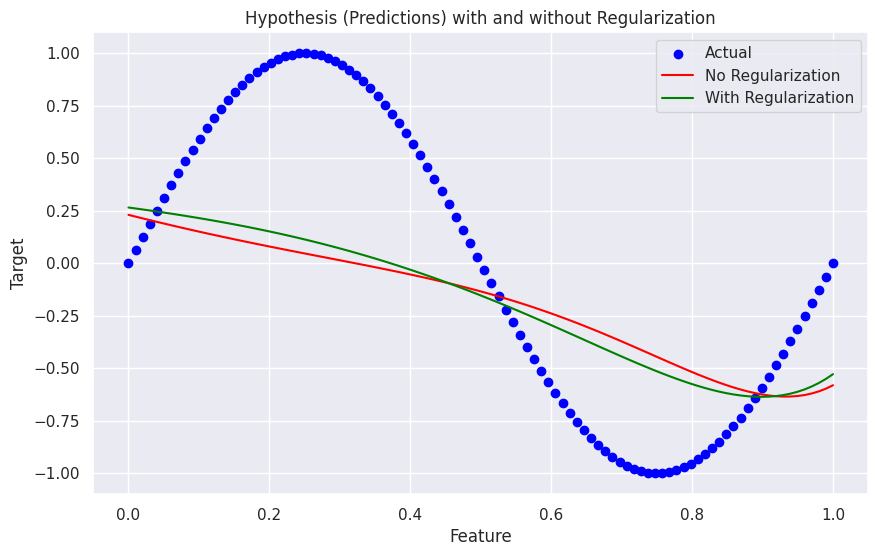

In [238]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 1].numpy(), y_test.numpy(), color='blue', label='Actual')
plt.plot(X_test[:, 1].numpy(), y_pred_no_reg.numpy(), color='red', label='No Regularization')
plt.plot(X_test[:, 1].numpy(), y_pred_reg.numpy(), color='green', label='With Regularization')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Hypothesis (Predictions) with and without Regularization')
plt.legend()
plt.show()

### Gradient Descent and Loss Equations

1. **Mean Squared Error (MSE) Loss**:
   $[
   \text{MSE} = \frac{1}{2m} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2
   $]
   where $( m$\) is the number of samples, $( y_i $) is the true value, and $( \hat{y}_i $) is the predicted value.

2. **Cost Function with Regularization**:
   $[
   J(\theta) = \text{MSE} + \frac{\alpha}{2} \sum_{j=1}^{n} \theta_j^2
   $]
   where $( \alpha $) is the regularization parameter, $( n $) is the number of features, and $( \theta $) are the model parameters.

3. **Gradient Update Rule**:
   $[
   \theta := \theta - \frac{\eta}{m} \nabla J(\theta)
   $]
   where $( \eta $) is the learning rate and $( \nabla J(\theta) $) is the gradient of the cost function with respect to $( \theta $).

4. **Gradient with Regularization**:
   $[
   \nabla J(\theta) = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x_i) - y_i)x_i + \alpha \theta
   $]
   where $( h_\theta(x_i) $) is the hypothesis function.

### Hyperparameters Used

- **Learning Rate** ($(\eta$)): $(0.01$)
- **Iterations**: $(1000$)
- **Regularization Parameter** ($(\alpha$)):
  - For SGD with regularization: $(0.01$)
  - For SGD without regularization: $(0.0$)
  - For SGD with a small regularization term: $(1 \times 10^{-3}$)
- **Momentum**: $(0.9$) (used only in SGD with Momentum)
